In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append('../Baseline/')
import baseline

In [2]:
df = pd.read_csv('data_with_classes_and_metros.csv')
df.shape

(3155, 14)

In [3]:
df.head(5)

Unnamed: 0   size class  price  pledge  near_metro  parking  internet  \
0           0   28.8     b   1354   39000       700.0        0         0   
1           1  588.2     b    850  500000       700.0        1         0   
2           2   45.0     b   1111   50000       200.0        1         0   
3           3  100.0     b   1700  170000       700.0        1         0   
4           4  190.0     c    789  150000      1200.0        0         1   

   meal  security  comfort        lat        lon  distance  
0     0         0        1  55.745093  37.664815   0.09581  
1     0         0        1  55.745093  37.664815   0.09581  
2     0         1        0  55.759659  37.752850   0.27184  
3     0         1        0  55.569026  37.588647   0.19060  
4     0         0        0  55.757496  37.802086   0.37023

In [4]:
df.drop(['Unnamed: 0'], inplace=True, axis=1)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['class'])
df['class'] = le.transform(df['class'])
df.head(5)

size  class  price  pledge  near_metro  parking  internet  meal  security  \
0   28.8      1   1354   39000       700.0        0         0     0         0   
1  588.2      1    850  500000       700.0        1         0     0         0   
2   45.0      1   1111   50000       200.0        1         0     0         1   
3  100.0      1   1700  170000       700.0        1         0     0         1   
4  190.0      2    789  150000      1200.0        0         1     0         0   

   comfort        lat        lon  distance  
0        1  55.745093  37.664815   0.09581  
1        1  55.745093  37.664815   0.09581  
2        0  55.759659  37.752850   0.27184  
3        0  55.569026  37.588647   0.19060  
4        0  55.757496  37.802086   0.37023

In [5]:
le.transform(['a', 'b', 'c', 'd'])

array([0, 1, 2, 3], dtype=int64)

In [6]:
#Смотрим observe_data
SIZE_CUT_VALUE = 700
PRICE_CUT_VALUE = 4500
df = df[(df.price < PRICE_CUT_VALUE) & (df['size'] < SIZE_CUT_VALUE)]

In [7]:
df.shape

(2929, 13)

# Попробуем решить задачу с помощью деревьев

### Посмотрим как просто на дереве все работает

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [9]:
X = df.drop(['price'],axis = 1)
y = df['price']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42 )

In [11]:
simple_model = DecisionTreeRegressor(max_depth=3, random_state=42)
simple_model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [12]:
print("train", np.sqrt(mean_squared_error(y_true=y_train, y_pred=simple_model.predict(X_train))))
print("test", np.sqrt(mean_squared_error(y_true=y_test, y_pred=simple_model.predict(X_test))))
print("baseline", np.sqrt(mean_squared_error(y_true=y_test, 
                                     y_pred=baseline.base_line_predict(
                                         X_test=X_test,
                                         X_train=X_train,
                                         y_train=y_train,
                                         numeric_class=True)
                                    ))
    )

train 577.412652913
test 535.511181538
baseline 609.977880682


Плохие признаки или данные

In [13]:
from sklearn.tree import export_graphviz
export_graphviz(simple_model, feature_names=X_train.columns, 
    out_file='small_tree.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
import pydot
(graph,) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')

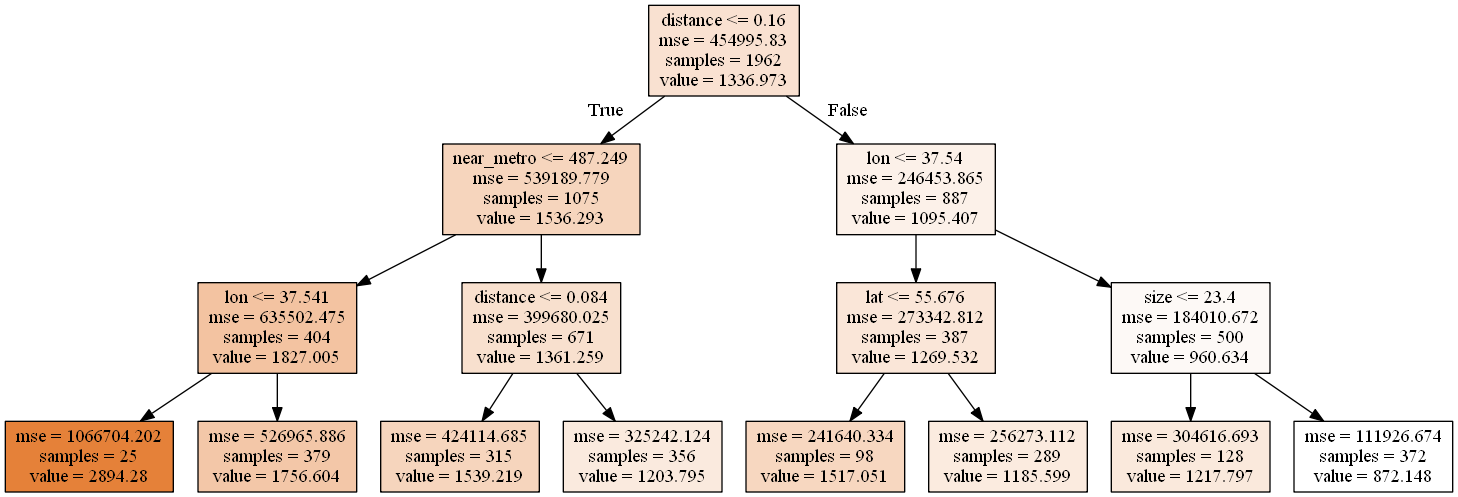

In [14]:
from IPython.core.display import Image, display
display(Image('small_tree.png', unconfined=True))

# Случайный лес

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

In [16]:
model = RandomForestRegressor(random_state=123, n_estimators=20, 
                               n_jobs=-1)

In [17]:
depths = np.arange(2, 20)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=132)
_, forest_valid_scores = validation_curve(model, X, y, 
                                         param_name='max_depth', 
                                         scoring = 'neg_mean_squared_error',
                                         param_range=depths, cv=cv, n_jobs=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


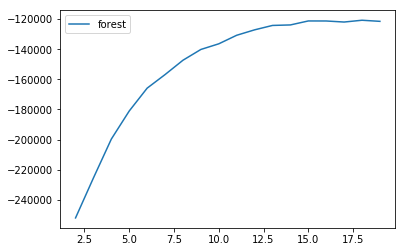

In [37]:
plt.plot(depths, forest_valid_scores.mean(axis=1), label='forest')
plt.legend()

In [18]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

In [19]:
print("train", np.sqrt(mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))))
print("test", np.sqrt(mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))))
print("baseline", np.sqrt(mean_squared_error(y_true=y_test, 
                                     y_pred=baseline.base_line_predict(
                                         X_test=X_test,
                                         X_train=X_train,
                                         y_train=y_train,
                                         numeric_class=True)
                                    ))
    )

train 170.730690322
test 369.012564489
baseline 609.977880682


In [40]:
export_graphviz(model.estimators_[0], feature_names=X_train.columns, 
    out_file='tree.dot', filled=True)
import pydot
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

In [41]:
from IPython.core.display import Image, display
display(Image('tree.png', unconfined=True))

# Теперь попробуем на с большим числом параметров

In [29]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
parameters = {'max_features': list(range(3,13)), 'min_samples_leaf': [1, 3, 5, 7, 10], 'max_depth': [5,10,15,20],
              'criterion': ['mse', 'mae']}

In [30]:
#     n_estimators — число деревьев в "лесу"
#     criterion — критерий для разбиения выборки в вершине
#     max_features — число признаков, по которым ищется разбиение
#     min_samples_leaf — минимальное число объектов в листе
#     max_depth — максимальная глубина дерева
rfc = RandomForestRegressor(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True)
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 7 folds for each of 400 candidates, totalling 2800 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=7.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed: 57.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'min_samples_leaf': [1, 3, 5, 7, 10], 'max_depth': [5, 10, 15, 20], 'criterion': ['mse', 'mae']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [39]:
gcv.best_params_

{'criterion': 'mse',
 'max_depth': 20,
 'max_features': 11,
 'min_samples_leaf': 1}

In [32]:
print("train", np.sqrt(mean_squared_error(y_true=y_train, y_pred=gcv.predict(X_train))))
print("test", np.sqrt(mean_squared_error(y_true=y_test, y_pred=gcv.predict(X_test))))
print("baseline", np.sqrt(mean_squared_error(y_true=y_test, 
                                     y_pred=baseline.base_line_predict(
                                         X_test=X_test,
                                         X_train=X_train,
                                         y_train=y_train,
                                         numeric_class=True)
                                    ))
    )

train 155.058586705
test 125.863550194
baseline 609.977880682


In [43]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42, 
                            n_jobs=-1, oob_score=True, max_depth=20,
                            min_samples_leaf=1, max_features=11)

In [44]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=11, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [45]:
print("train", np.sqrt(mean_squared_error(y_true=y_train, y_pred=rfr.predict(X_train))))
print("test", np.sqrt(mean_squared_error(y_true=y_test, y_pred=rfr.predict(X_test))))
print("baseline", np.sqrt(mean_squared_error(y_true=y_test, 
                                     y_pred=baseline.base_line_predict(
                                         X_test=X_test,
                                         X_train=X_train,
                                         y_train=y_train,
                                         numeric_class=True)
                                    ))
    )

train 161.886769409
test 348.023528777
baseline 609.977880682
